In [11]:
import pandas as pd
import librosa
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import librosa
import numpy as np

def normalize_audio(audio):
    """
    Normalize the amplitude of an audio signal to the range [-1, 1].

    Args:
        audio (numpy array): Audio time series.

    Returns:
        numpy array: Normalized audio.
    """
    return librosa.util.normalize(audio)


def extract_mfcc(audio, sample_rate=22050, n_mfcc=13):
    """
    Extract MFCC features from audio.
    """
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to make time-steps first

def extract_spectrogram(audio, sample_rate=22050, n_mels=128):
    """
    Extract log-Mel spectrogram from audio.
    """
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmax=sample_rate // 2)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram.T  # Transpose to make time-steps first

def extract_zcr(audio):
    """
    Extract Zero Crossing Rate (ZCR) from audio.

    Args:
        audio (numpy array): Audio time series.

    Returns:
        numpy array: Zero crossing rate values.
    """
    zcr = librosa.feature.zero_crossing_rate(audio)
    return zcr.T  # Transpose to make time-steps first

In [ ]:
def process_dataset(csv_path, sample_rate=22050, duration=5):
    """
    Process dataset to extract features (MFCCs, Spectrograms, Pitch, ZCR) and labels.

    Args:
        csv_path (str): Path to the CSV file containing file paths and labels.
        sample_rate (int): Sampling rate for audio loading.
        duration (int): Duration (in seconds) to which all audio will be trimmed or padded.

    Returns:
        tuple: Individual features (MFCCs, Spectrograms, Pitch, ZCR), combined features, and labels.
    """
    df = pd.read_csv(csv_path)

    combined_features_list = []
    mfcc_list, spectrogram_list, pitch_list, zcr_list = [], [], [], []
    labels = []
    processed_files = 0

    for index, row in df.iterrows():
        file_path = row['filtered_filepath']
        label = row['class']

        try:
            print(f"Processing file {index + 1}/{len(df)}: {file_path}")

            # Load and preprocess audio
            audio, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
            audio = librosa.util.fix_length(audio, size=sample_rate * duration)
            audio = normalize_audio(audio)

            # Extract features
            mfcc = extract_mfcc(audio, sample_rate=sr)
            spectrogram = extract_spectrogram(audio, sample_rate=sr)
            zcr = extract_zcr(audio)

            # Reshape Pitch and ZCR to match time steps of MFCC
            zcr = zcr[:mfcc.shape[0], :]  # Trim ZCR to match the time steps of MFCC

            # Combine all features (MFCC, Spectrogram, ZCR)
            combined_features = np.concatenate((mfcc, spectrogram, zcr), axis=-1)  # Corrected variable name

            # Append to respective lists
            mfcc_list.append(mfcc)
            spectrogram_list.append(spectrogram)
            zcr_list.append(zcr)
            combined_features_list.append(combined_features)
            labels.append(label)

            processed_files += 1

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    print(f"Feature extraction completed. Processed {processed_files} files.")

    # Return individual features, combined features, and labels
    return mfcc_list, spectrogram_list, zcr_list, combined_features_list, labels


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

def prepare_data(features, labels, target_shape=(128, 128)):
    """
    Prepare data for training and testing with balanced classes and consistent shapes.

    Args:
        features (list of numpy arrays): List of feature arrays.
        labels (list): List of corresponding labels.
        target_shape (tuple): Target shape (height, width) for features.

    Returns:
        tuple: (X_train, X_test, y_train, y_test, unique_labels)
    """
    # Create a DataFrame for easier manipulation
    data = pd.DataFrame({'features': features, 'labels': labels})

    # Balance classes by resampling
    balanced_data = []
    max_samples = data['labels'].value_counts().max()
    for label in data['labels'].unique():
        class_data = data[data['labels'] == label]
        balanced_class_data = resample(class_data, replace=True, n_samples=max_samples, random_state=42)
        balanced_data.append(balanced_class_data)

    # Concatenate balanced data and shuffle
    balanced_data = pd.concat(balanced_data).sample(frac=1, random_state=42)

    # Separate features and labels from balanced data
    balanced_features = balanced_data['features'].tolist()
    balanced_labels = balanced_data['labels'].tolist()

    # Process features to ensure consistent shape
    processed_features = []
    for feature in balanced_features:
        if feature.shape[0] <= target_shape[0] and feature.shape[1] <= target_shape[1]:
            # Pad feature to target shape
            padded_feature = np.pad(feature,
                                    ((0, target_shape[0] - feature.shape[0]),
                                     (0, target_shape[1] - feature.shape[1])),
                                    mode='constant')
        else:
            # Crop feature to target shape
            padded_feature = feature[:target_shape[0], :target_shape[1]]
        processed_features.append(padded_feature)

    # Convert features to a 4D numpy array (samples, height, width, channels)
    processed_features = np.array(processed_features)
    processed_features = np.expand_dims(processed_features, -1)  # Add a channel dimension

    # Encode labels to numeric values and then to one-hot encoding
    unique_labels = sorted(set(balanced_labels))
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_index[label] for label in balanced_labels])
    one_hot_labels = to_categorical(numeric_labels, num_classes=len(unique_labels))

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(processed_features, one_hot_labels,
                                                        test_size=0.2, stratify=numeric_labels,
                                                        random_state=42)

    return X_train, X_test, y_train, y_test, unique_labels


In [13]:
def build_cnn(input_shape, num_classes):
    """
    Build a CNN model for classification.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
final_dataset_path = '/content/drive/My Drive/SNSProject/musan-dataset/musan/final_updated_musan_dataset.csv'

In [ ]:
mfccs,spectrograms, zcrs, combined_features, labels = process_dataset(final_dataset_path)

Processing file 1/2016: /content/drive/My Drive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0149.wav
Processing file 2/2016: /content/drive/My Drive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0077.wav
Processing file 3/2016: /content/drive/My Drive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0105.wav
Processing file 4/2016: /content/drive/My Drive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0034.wav
Processing file 5/2016: /content/drive/My Drive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0032.wav
Processing file 6/2016: /content/drive/My Drive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0059.wav
Processing file 7/2016: /content/drive/My Drive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0107.wav
Processing file 8/2016: /content/drive/My Drive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0170.wav
Processing file 9/2016: /content/drive/M

In [ ]:
X_train, X_test, y_train, y_test, unique_labels = prepare_data(combined_features, labels)

In [ ]:
import numpy as np
import os
os.makedirs('/content/drive/MyDrive/SNSProject/data/', exist_ok=True)
# Save data to .npz format
np.savez('/content/drive/MyDrive/SNSProject/data/train_test_data_final2.npz',
         X_train=X_train, X_test=X_test,
         y_train=y_train, y_test=y_test,
         unique_labels=unique_labels)

In [14]:
import numpy as np

# Define the file path where the npz file is saved
npz_file_path = '/content/drive/MyDrive/SNSProject/data/train_test_data_final2.npz'

# Load the data from the npz file
data = np.load(npz_file_path)

# Access the data by the keys you used when saving
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
unique_labels = data['unique_labels']

# Verify that data has been loaded
print("Data has been loaded successfully")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Unique labels: {unique_labels}")


Data has been loaded successfully
X_train shape: (2232, 128, 128, 1)
X_test shape: (558, 128, 128, 1)
y_train shape: (2232, 3)
y_test shape: (558, 3)
Unique labels: ['music' 'noise' 'speech']


In [15]:
cnn_model = build_cnn(input_shape=X_train.shape[1:], num_classes=len(unique_labels))

In [16]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,108,483 (19.49 MB)

 Trainable params: 5,108,483 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 297ms/step - accuracy: 0.3987 - loss: 19.7503 - val_accuracy: 0.6183 - val_loss: 0.7683
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6673 - loss: 0.6790 - val_accuracy: 0.6667 - val_loss: 0.5821
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7175 - loss: 0.5647 - val_accuracy: 0.8100 - val_loss: 0.4235
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8026 - loss: 0.4622 - val_accuracy: 0.8333 - val_loss: 0.3682
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8260 - loss: 0.3957 - val_accuracy: 0.8799 - val_loss: 0.3314
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8365 - loss: 0.3812 - val_accuracy: 0.8459 - val_loss: 0.3151
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8702 - loss: 0.3225 - val_accuracy: 0.8351 - val_loss: 0.3204
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8764 - loss: 0.3063 - val_accuracy: 0.8602 

In [18]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9087 - loss: 0.2691
Test Loss: 0.2686331272125244
Test Accuracy: 0.9103942513465881


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Predict on the test data
predictions = cnn_model.predict(X_test)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels (y_test) from one-hot encoding to class labels
true_labels = np.argmax(y_test, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


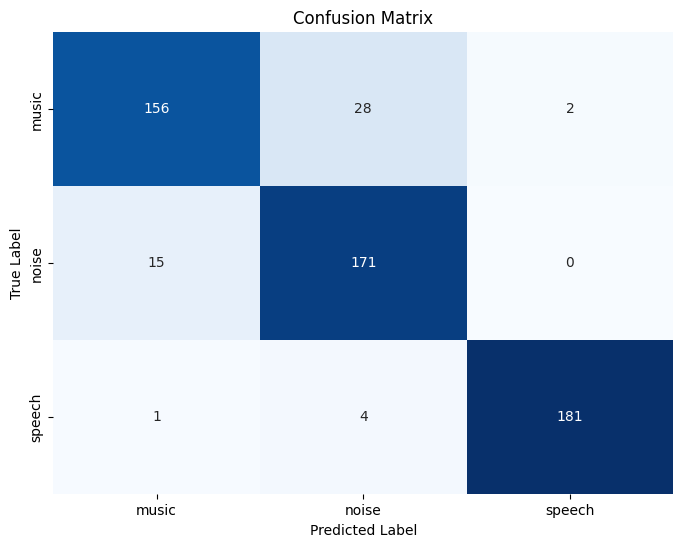

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels, cbar=False)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [22]:
cnn_model.save('/content/drive/MyDrive/SNSProject/SNSPROJECTCNNMODELfinalfinal.keras')

In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)  # y is the audio signal, sr is the sampling rate

    # Generate the spectrogram (STFT)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()



<ipython-input-23-1783eae1427c>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


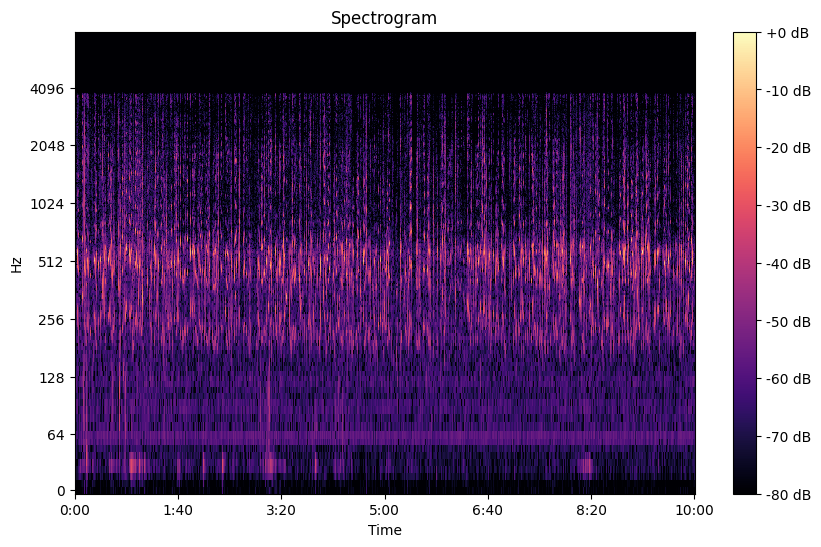

In [24]:
# Example usage:
file_path = '/content/drive/MyDrive/SNSProject/musan-dataset/musan/speech/us-gov/speech-us-gov-0000.wav'  # Replace with your actual file path
plot_spectrogram(file_path)

<ipython-input-23-1783eae1427c>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


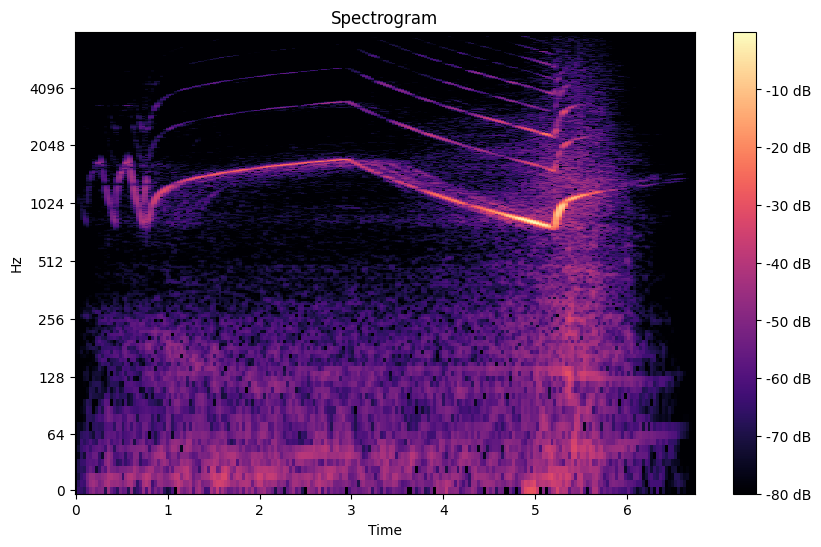

In [25]:
# Example usage:
file_path = '/content/drive/MyDrive/SNSProject/musan-dataset/musan/noise/sound-bible/noise-sound-bible-0000.wav'  # Replace with your actual file path
plot_spectrogram(file_path)

<ipython-input-23-1783eae1427c>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


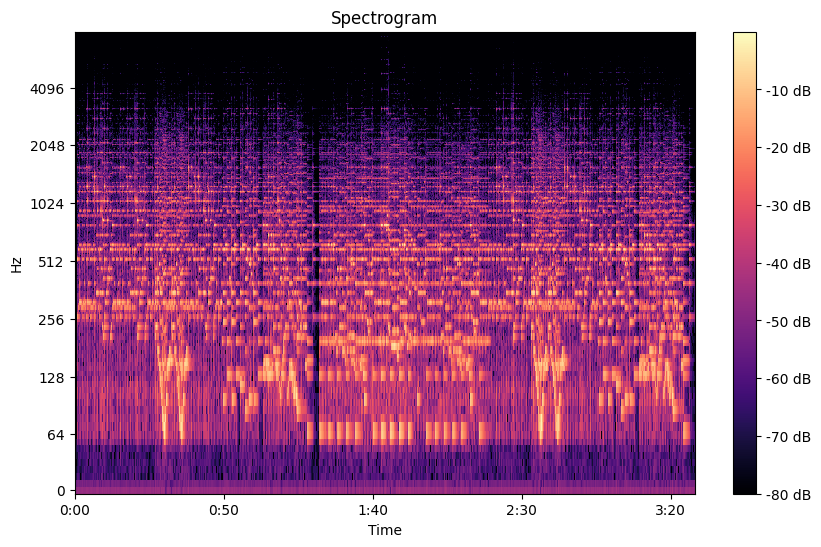

In [26]:
# Example usage:
file_path = '/content/drive/MyDrive/SNSProject/musan-dataset/musan/music/hd-classical/music-hd-0000.wav'  # Replace with your actual file path
plot_spectrogram(file_path)

In [27]:
import librosa
import numpy as np

def normalize_audio(audio):
    """
    Normalize the amplitude of an audio signal to the range [-1, 1].

    Args:
        audio (numpy array): Audio time series.

    Returns:
        numpy array: Normalized audio.
    """
    return librosa.util.normalize(audio)


def extract_mfcc(audio, sample_rate=22050, n_mfcc=13):
    """
    Extract MFCC features from audio.
    """
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to make time-steps first

def extract_spectrogram(audio, sample_rate=22050, n_mels=128):
    """
    Extract log-Mel spectrogram from audio.
    """
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmax=sample_rate // 2)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram.T  # Transpose to make time-steps first

def extract_zcr(audio):
    """
    Extract Zero Crossing Rate (ZCR) from audio.

    Args:
        audio (numpy array): Audio time series.

    Returns:
        numpy array: Zero crossing rate values.
    """
    zcr = librosa.feature.zero_crossing_rate(audio)
    return zcr.T  # Transpose to make time-steps first

def predict_audio_file(model, file_path, sample_rate=22050, duration=60, target_shape=(128, 128)):
    """
    Predict the class of a single audio file using the trained CNN model.

    Args:
        model (keras.Model): The trained CNN model.
        file_path (str): Path to the audio file.
        sample_rate (int): Sampling rate for audio loading.
        duration (int): Duration of audio in seconds to load.
        target_shape (tuple): Shape to which the audio features should be padded or cropped.

    Returns:
        tuple: Predicted class label and the probability for each class.
    """
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
    audio = librosa.util.fix_length(audio, size=sample_rate * duration)  # Ensure correct length
    audio = normalize_audio(audio)  # Normalize audio amplitude

    # Extract features (MFCC, Spectrogram, and Pitch)
    mfcc = extract_mfcc(audio, sample_rate=sr)
    spectrogram = extract_spectrogram(audio, sample_rate=sr)
    zcr = extract_zcr(audio)

    # Add pitch as a feature (reshaped to match dimensions)
    zcr = zcr[:mfcc.shape[0], :]  # Trim ZCR to match the time steps of MFCC

    # Combine MFCC, Spectrogram, and Pitch features
    combined_features = np.concatenate((mfcc, spectrogram, zcr), axis=-1)

    # Pad or crop to the target shape
    if combined_features.shape[0] <= target_shape[0] and combined_features.shape[1] <= target_shape[1]:
        padded_feature = np.pad(combined_features,
                               ((0, target_shape[0] - combined_features.shape[0]),
                                (0, target_shape[1] - combined_features.shape[1])),
                               mode='constant')
    else:
        # Crop if feature is larger than target shape
        padded_feature = combined_features[:target_shape[0], :target_shape[1]]

    # Ensure that the input is a 4D tensor with shape (batch_size, height, width, channels)
    input_data = np.expand_dims(padded_feature, axis=-1)  # Shape will be (128, 128, 1)

    # Add batch dimension: (1, 128, 128, 1)
    input_data = np.expand_dims(input_data, axis=0)  # Shape will be (1, 128, 128, 1)

    # Make prediction
    predictions = model.predict(input_data)

    # Get the predicted class index (highest probability)
    predicted_class_index = np.argmax(predictions)

    # Get the probability for each class (as percentages)
    class_probabilities = predictions[0] * 100  # Convert to percentage

    # Assuming you have the unique labels (from training data) to map the predicted index to the label
    unique_labels = ['music', 'noise', 'speech']  # Replace with your actual labels
    predicted_class_label = unique_labels[predicted_class_index]

    return predicted_class_label, class_probabilities


In [28]:
from tensorflow.keras.models import load_model

# Load the pre-trained CNN model from the specified file path
model = load_model('/content/drive/MyDrive/SNSProject/SNSPROJECTCNNMODELfinalfinal.keras')

In [31]:
file_path = '/content/drive/MyDrive/SNSProject/musan-dataset/musan/music/fma-western-art/music-fma-wa-0001.wav'
predicted_class_label, class_probabilities = predict_audio_file(model, file_path)
# Round the probabilities for better readability
rounded_probabilities = np.round(class_probabilities, 2)

# Print the results
print(f"Predicted class: {predicted_class_label}")
print(f"Class probabilities: {rounded_probabilities}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: music
Class probabilities: [9.303e+01 6.960e+00 1.000e-02]


In [37]:
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define functions from previous code (normalize_audio, add_rayleigh_noise, etc.)

def normalize_audio(audio):
    return librosa.util.normalize(audio)

def add_rayleigh_noise(audio, scale=0.05):
    """
    Add Rayleigh noise to the audio signal.

    Args:
        audio (numpy array): The original audio signal.
        scale (float): The scale parameter for the Rayleigh distribution (controls noise intensity).

    Returns:
        numpy array: The audio signal with Rayleigh noise added.
    """
    rayleigh_noise = np.random.rayleigh(scale, audio.shape)
    noisy_audio = audio + rayleigh_noise
    return noisy_audio

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

def plot_signals(original_audio, noisy_audio, filtered_audio, sr, duration):
    time = np.linspace(0, duration, len(original_audio))

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(time, original_audio, label='Original Audio', color='blue')
    plt.title('Original Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time, noisy_audio, label='Noisy Audio (Rayleigh)', color='red')
    plt.title('Audio Signal with Rayleigh Noise')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time, filtered_audio, label='Filtered Audio', color='green')
    plt.title('Filtered Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def extract_mfcc(audio, sample_rate=22050, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc.T

def extract_spectrogram(audio, sample_rate=22050, n_mels=128):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmax=sample_rate // 2)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram.T

def extract_zcr(audio):
    zcr = librosa.feature.zero_crossing_rate(audio)
    return zcr.T

def predict_audio_file(model, file_path, sample_rate=22050, duration=60, target_shape=(128, 128)):
    audio, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
    audio = librosa.util.fix_length(audio, size=sample_rate * duration)
    audio = normalize_audio(audio)

    # Add Rayleigh noise
    noisy_audio = add_rayleigh_noise(audio)

    # Apply low-pass filter to remove noise
    filtered_audio = butter_lowpass_filter(noisy_audio, cutoff=3000, fs=sr)

    # Plot the signals
    plot_signals(audio, noisy_audio, filtered_audio, sr, duration)

    # Extract features (MFCC, Spectrogram, and ZCR)
    mfcc = extract_mfcc(filtered_audio, sample_rate=sr)
    spectrogram = extract_spectrogram(filtered_audio, sample_rate=sr)
    zcr = extract_zcr(filtered_audio)

    # Combine features
    combined_features = np.concatenate((mfcc, spectrogram, zcr), axis=-1)

    # Pad or crop to the target shape
    if combined_features.shape[0] <= target_shape[0] and combined_features.shape[1] <= target_shape[1]:
        padded_feature = np.pad(combined_features,
                               ((0, target_shape[0] - combined_features.shape[0]),
                                (0, target_shape[1] - combined_features.shape[1])),
                               mode='constant')
    else:
        padded_feature = combined_features[:target_shape[0], :target_shape[1]]

    # Ensure the input is 4D
    input_data = np.expand_dims(padded_feature, axis=-1)
    input_data = np.expand_dims(input_data, axis=0)

    # Make prediction
    predictions = model.predict(input_data)

    # Get predicted class and probabilities
    predicted_class_index = np.argmax(predictions)
    class_probabilities = predictions[0] * 100  # Convert to percentage

    unique_labels = ['music', 'noise', 'speech']  # Replace with your actual labels
    predicted_class_label = unique_labels[predicted_class_index]

    return predicted_class_label, class_probabilities

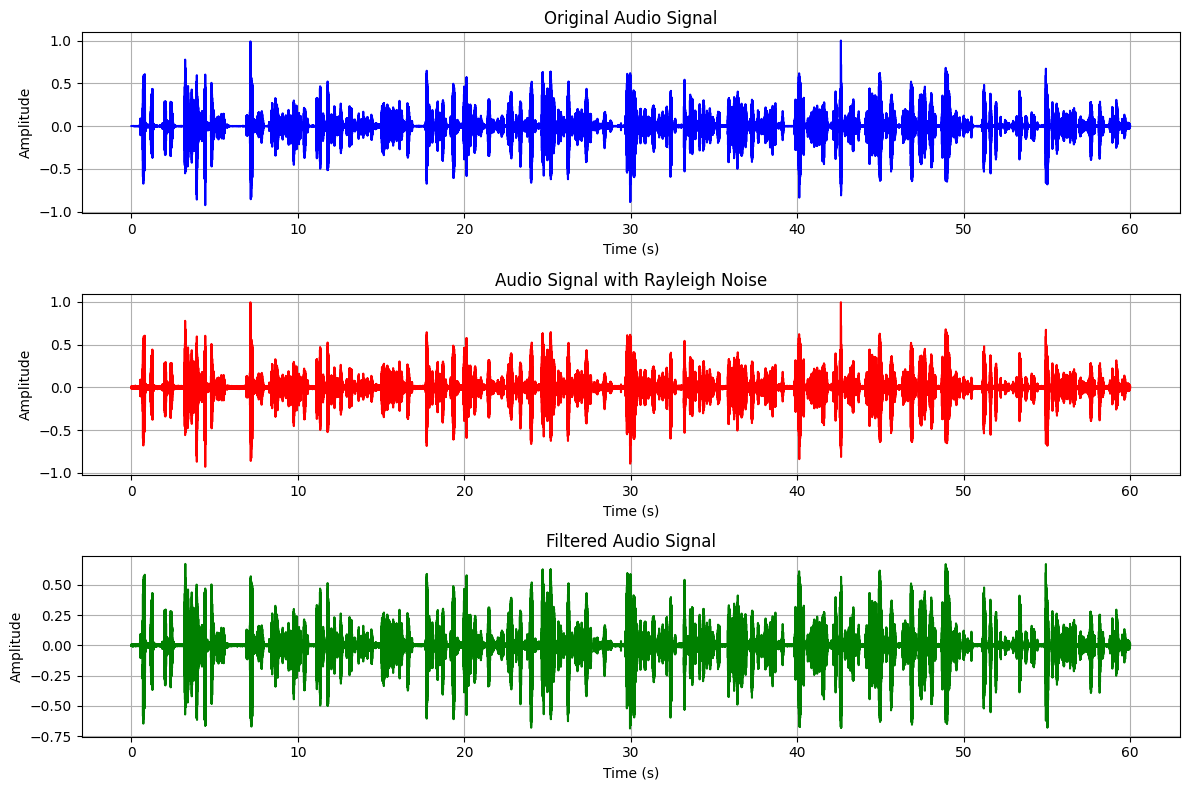

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: speech
Class probabilities: [2.000e-02 6.000e-02 9.992e+01]


In [39]:
file_path = '/content/drive/MyDrive/SNSProject/musan-dataset/musan/speech_filtered/speech-librivox-0002.wav'
predicted_class_label, class_probabilities = predict_audio_file_withnoise(model, file_path)
# Round the probabilities for better readability
rounded_probabilities = np.round(class_probabilities, 2)

# Print the results
print(f"Predicted class: {predicted_class_label}")
print(f"Class probabilities: {rounded_probabilities}")
